## Задача: построить модель кластеризации для определения сегментов клиентов по метрикам их затрат.

### Шаг 1.
### Импорт библиотек, анализ и подготовка данных.

#### - Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

#### - Загрузка и предварительный анализ загруженых данных.

In [2]:
df = pd.read_csv('data.csv')
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


#### - Анализ загруженных данных.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

#### Название колонок поменяем на lower_case. Видим что у credit_limit и minumim_payments присутствуют пропуски,заменим их на медианные значения, чтобы избежать потерю данных и избежать появления аномалий.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df['credit_limit'] = df['credit_limit'].fillna(df['credit_limit'].median())
df['minimum_payments'] = df['minimum_payments'].fillna(df['minimum_payments'].median())

In [6]:
df.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


#### Уберем колонку cust_id так как она не имеет пресказательного значения.

In [10]:
df = df.drop(['cust_id'], axis=1)

#### - Визуальный анализ фичей.

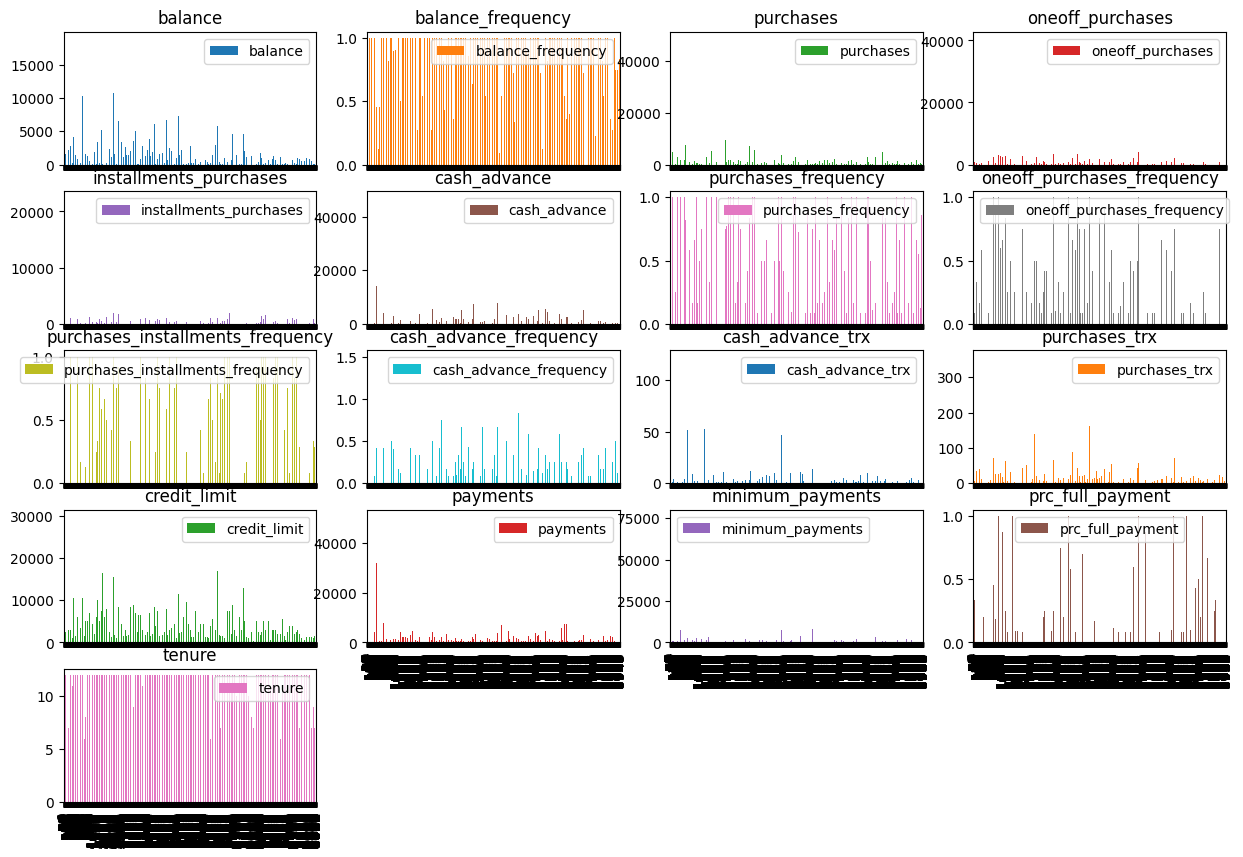

In [7]:
df.plot(kind = 'bar', subplots = True, layout=(5,4), figsize=(15, 10))

plt.show()

#### - Скейлинг данных для модели кластеризации.

In [11]:
numeric_features = list(df.columns)
scaler = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features)
    ]
)

In [12]:
X_processed = preprocessor.fit_transform(df)

### Шаг 2.
### Тренинг модели. Поиск оптимального значения k, через метод локтя и метрики silhouette_score.

#### - Импорт библиотек

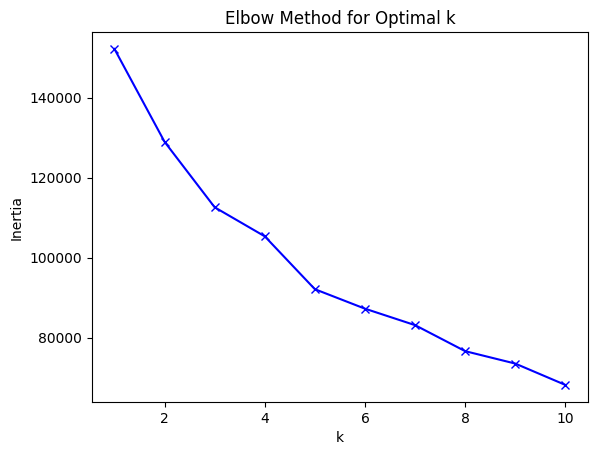

In [13]:
inertia = []
K = range(1, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_processed)
    inertia.append(model.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

#### - Метод локтя не помогает определить оптимальное значение k, так как отсутствует резкое падение в инерции.

In [14]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    print(f"k={k}, silhouette={silhouette_score(X_processed, labels):.3f}")

k=2, silhouette=0.280
k=3, silhouette=0.207
k=4, silhouette=0.166
k=5, silhouette=0.193
k=6, silhouette=0.192
k=7, silhouette=0.215
k=8, silhouette=0.204
k=9, silhouette=0.204


#### - Метод силуэта показывает что оптимальное значение k, из перепробованных - 2.

#### - Тренировка модели с оптимальным количеством кластеров.

In [15]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_processed)
df['cluster'] = labels

#### - Группировка по кластерам и аггрегирование среднего.

In [16]:
cluster_summary = df.groupby('cluster').mean()
display(cluster_summary)

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
cluster,,,,,,,,,,,,,,,,,
0,2147.310087,0.979774,3364.893645,2075.077145,1290.139081,761.443235,0.937914,0.588182,0.712940,0.082253,2.232258,46.131183,7182.543988,3595.423358,1195.056462,0.285596,11.891935
1,1411.573053,0.850380,383.636260,203.479687,180.450879,1035.911430,0.372936,0.101266,0.273011,0.149020,3.515515,6.466714,3789.040383,1244.590977,753.048031,0.119117,11.419041


#### - Первый кластер - люди с высоким балансом, большим количеством транзакций, частыми покупками, но более низким cash_advance.  Активные потребители.
#### - Второй кластер - люди с низким балансом, малым  количеством транзакций, редкими покупками, но более высоким cash_advance.  Осторожные покупатели.

#### - Усреднение метрик для используемых для визуального анализа.

In [17]:
cluster_summary = df.groupby('cluster')[['purchases', 'credit_limit', 'payments', 
                                         'minimum_payments', 'purchases_frequency', 
                                         'oneoff_purchases_frequency', 'balance', 'tenure']].mean()
display(cluster_summary)

,purchases,credit_limit,payments,minimum_payments,purchases_frequency,oneoff_purchases_frequency,balance,tenure
cluster,,,,,,,,
0,3364.893645,7182.543988,3595.423358,1195.056462,0.937914,0.588182,2147.310087,11.891935
1,383.636260,3789.040383,1244.590977,753.048031,0.372936,0.101266,1411.573053,11.419041


#### - Сохранение скейлера и модели в файлы.

In [18]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']

### Шаг 3.
### Визуальный анализ различных пар метрик.

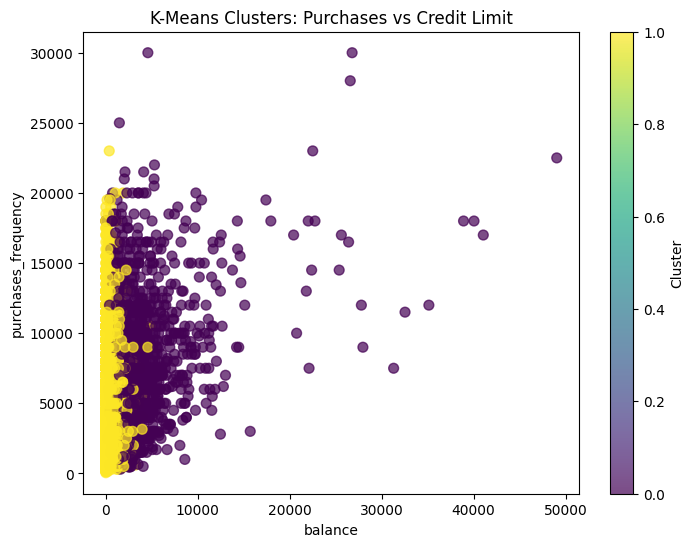

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(df['purchases'], df['credit_limit'], 
            c=df['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.xlabel('balance')
plt.ylabel('purchases_frequency')
plt.title('K-Means Clusters: Purchases vs Credit Limit')
plt.colorbar(label='Cluster')
plt.show()

#### Активные потребители - фиолетовый. частота покупок растет с балансом.

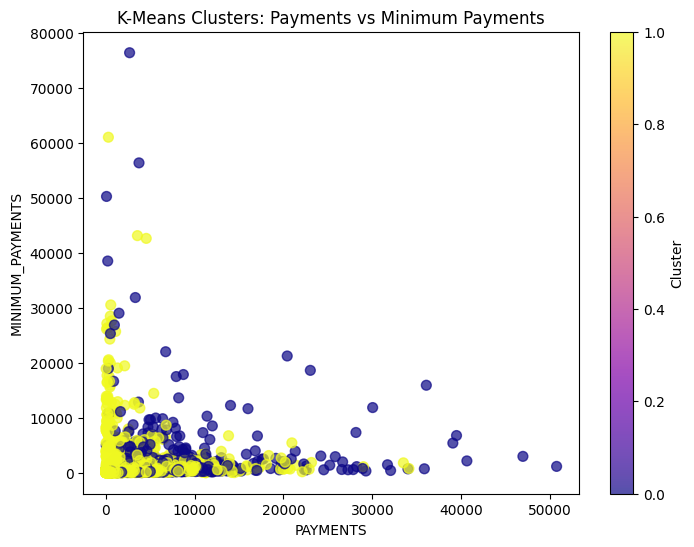

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(df['payments'], df['minimum_payments'], 
            c=kmeans.labels_, cmap='plasma', s=50, alpha=0.7)
plt.xlabel('PAYMENTS')
plt.ylabel('MINIMUM_PAYMENTS')
plt.title('K-Means Clusters: Payments vs Minimum Payments')
plt.colorbar(label='Cluster')
plt.show()

#### Активные потребители - синий. По сравнению с осторожными покупателями, большее кол-во плат(payments), для низких минимальных плат.

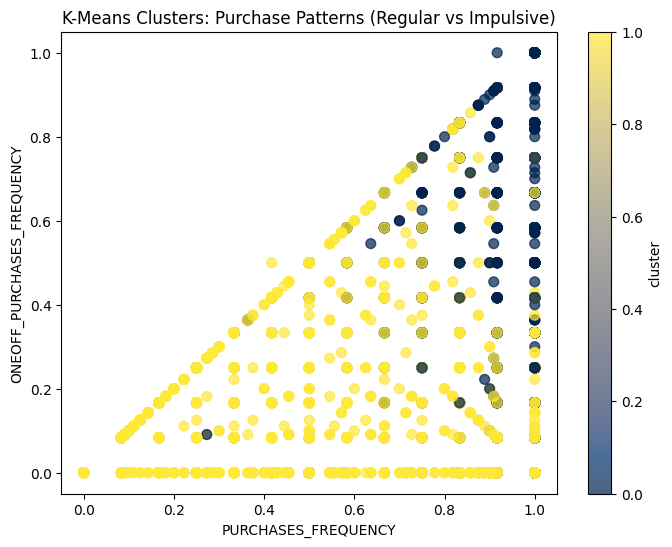

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(df['purchases_frequency'], df['oneoff_purchases_frequency'], 
            c=df['cluster'], cmap='cividis', s=50, alpha=0.7)
plt.xlabel('PURCHASES_FREQUENCY')
plt.ylabel('ONEOFF_PURCHASES_FREQUENCY')
plt.title('K-Means Clusters: Purchase Patterns (Regular vs Impulsive)')
plt.colorbar(label='cluster')
plt.show()

#### Осторожными покупателями(синий) производится много покупок за 1 поход.

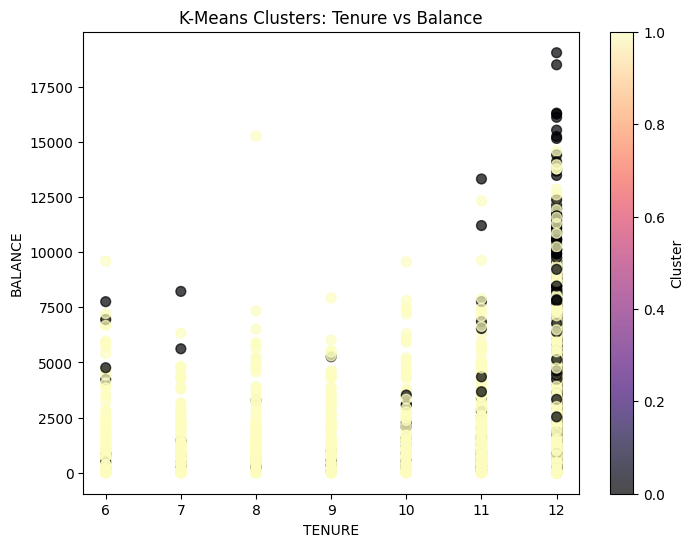

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(df['tenure'], df['balance'], 
            c=df['cluster'], cmap='magma', s=50, alpha=0.7)
plt.xlabel('TENURE')
plt.ylabel('BALANCE')
plt.title('K-Means Clusters: Tenure vs Balance')
plt.colorbar(label='Cluster')
plt.show()

#### У осторожных покупателей высокий tenure коррелирует с высоким балансом.